In [1]:
import wandb
from condgen.models.score_matching import ConditionalScoreMatcher
from condgen.models.deepscm import DeepSCM
from condgen.data_utils.data_utils_MNIST import MNISTDataModule
from condgen.data_utils.data_utils_cf_traj import SimpleTrajDataModule
from condgen.models import samplers
from condgen.glow.model import GlowModel
import pytorch_lightning as pl
import torch
import numpy as np
import os

from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tqdm 
import pandas as pd

/home/edward/.cache/pypoetry/virtualenvs/condgen-8jXrSjT1-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
gpu = 0
api = wandb.Api()

run = api.run(f"edebrouwer/counterfactuals/2bvwjnc7")

In [19]:
model_cls = GlowModel
dataset_cls = MNISTDataModule


fname = [f.name for f in run.files() if "ckpt" in f.name][0]
run.file(fname).download(replace = True, root = ".")
model = model_cls.load_from_checkpoint(fname)
os.remove(fname)
    
hparams = dict(model.hparams)
dataset = dataset_cls(**hparams)
dataset.prepare_data()

In [20]:
device = torch.device("cuda:0")
model = model.to(device)

In [21]:
for i,b in enumerate(dataset.test_cf_dataloader()):
    X_cond, X_true, _, T_cond, T_new, X_new = b
    break

## Sampling

In [22]:
z_samples = model.abduct(X = X_cond.to(device), Y = X_true.to(device), T = T_cond.to(device))

In [26]:
cf_samples = model.sample(Y_shape = z_samples.shape, z_init = z_samples, X = X_cond.to(device), T = T_cond.to(device), temperature = 0.1)

In [27]:
#(cf_samples.cpu()/255-X_new).pow(2).mean()

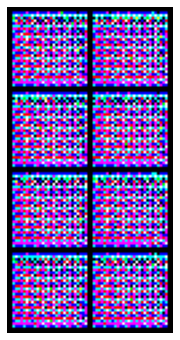

In [28]:
num_to_plot = 8
cf_samples = (cf_samples)

sample_grid = make_grid(cf_samples[:num_to_plot], nrow=int(np.sqrt(num_to_plot)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [10]:
cf_samples.max()

tensor(255, dtype=torch.uint8)

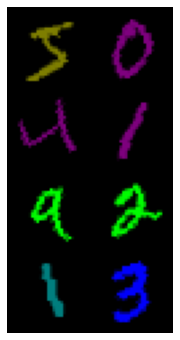

In [30]:
true_cf = X_new.clamp(0.0, 1.0)[:sample_batch_size]

sample_grid = make_grid(true_cf, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

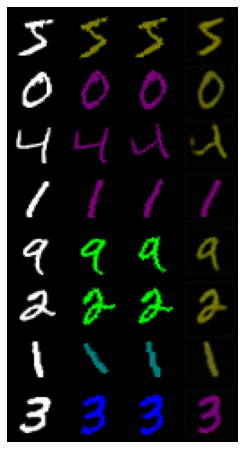

In [39]:
x_og = X_cond[:sample_batch_size].clamp(0.0,1.0).to(device)
og_grid = make_grid(x_og, nrow=1)

x_obs = X_true[:sample_batch_size].clamp(0.0,1.0).to(device)
obs_grid = make_grid(x_obs, nrow=1)

x_cf = X_new[:sample_batch_size].clamp(0.0,1.0).to(device)
cf_grid = make_grid(x_cf, nrow=1)

x_pred = cf_samples.clamp(0.0,1.0).to(device)
pred_grid = make_grid(x_pred, nrow=1)

all_grid = torch.cat((og_grid,obs_grid,cf_grid,pred_grid),2)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(all_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [81]:
def evaluate_run(run,dataset_cls):
    model_cls = ConditionalScoreMatcher

    fname = [f.name for f in run.files() if "ckpt" in f.name][0]
    run.file(fname).download(replace = True, root = ".")
    model = model_cls.load_from_checkpoint(fname)
    os.remove(fname)

    hparams = dict(model.hparams)
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()

    device = torch.device("cuda:0")
    model = model.to(device)

    X_pred_cf = []
    X_target_cf = []
    X_cond_list = []
    Y_fact_list = []
    for i,b in tqdm.tqdm(enumerate(dataset.test_cf_dataloader())):
        X_cond, X_true, _, T_cond, T_new, X_new = b
        sampler = samplers.ode_sampler
        #abduction
        z_samples = model.abduct(X = X_cond.to(device), Y = X_true.to(device), T = T_cond.to(device))
        cf_samples = model.sample(Y_shape = z_samples.shape, z_init = z_samples, X = X_cond.to(device), T = T_cond.to(device))
        #cf_samples = model.sample(sampler, sample_batch_size = X_cond.shape[0], X_cond = X_cond.to(device), T_cond = T_new.to(device),z = z_samples)
        X_pred_cf.append(cf_samples)
        X_target_cf.append(X_new)
        X_cond_list.append(X_cond)
        Y_fact_list.append(X_true)

    X_pred_cf = torch.cat(X_pred_cf)
    X_target_cf = torch.cat(X_target_cf)
    X_cond = torch.cat(X_cond_list)
    Y_factual = torch.cat(Y_fact_list)

    mse = (X_pred_cf.cpu()-X_target_cf.cpu()).pow(2).mean()
    
    return mse, X_pred_cf, X_target_cf, X_cond, Y_factual

#mse = evaluate_run(run,dataset_cls = SimpleTrajDataModule)

In [6]:
"""
configs = [{"sweep_id":["rp1tjzby"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":MNISTDataModule,
  "model_name":"Diffusion",
  "data_name":"MNIST",
  "config_name":f"Diffusion abduction"}]


configs = [{"sweep_id":["1nbculs1"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":SimpleTrajDataModule,
  "model_name":"Diffusion",
  "data_name":"SimpleTraj",
  "config_name":f"Diffusion abduction"}]

"""

configs = [{"sweep_id":["7a8w8o9b"],
  "model_cls":ConditionalScoreMatcher,
  "data_cls":SimpleTrajDataModule,
  "model_name":"Diffusion",
  "data_name":"CV",
  "config_name":f"Diffusion abduction"}]

In [7]:
fold_name = "random_seed"
df = pd.DataFrame()
api = wandb.Api()

for config in configs:

    pd_dict = {"Model":config["model_name"],"Data":config["data_name"], "Name":config["config_name"]}
    sweep_names = [sweep_id for sweep_id in config["sweep_id"]]
    
    model_cls = config["model_cls"]
    # Gathering runs from sweeps -----
    sweeps = [api.sweep(f"edebrouwer/counterfactuals/{sweep_name}") for sweep_name in sweep_names]
    sweep_runs = []
    for sweep in sweeps:
        sweep_runs += [r for r in sweep.runs]
        
    best_runs = []
    for fold in [421,422,423,424,425]:

        runs_fold = [r for r in sweep_runs if (r.config.get(fold_name)==fold) and (r.config.get("data_type")==config["data_name"])]
        if "groups" in config:
            for group_key in config["groups"].keys():
                runs_fold = [r for r in runs_fold if (r.config.get(group_key)==config["groups"][group_key])]
        
        runs_fold_sorted = sorted(runs_fold,key = lambda run: run.summary.get("restored_val_loss"), reverse = False)
        best_runs.append(runs_fold_sorted[0])
        
    mses = []
    for run in best_runs:
        mse = evaluate_run(run,dataset_cls = config["data_cls"])[0]
        mses.append(mse)
    mses = np.array(mses)
    mse_mu = mses.mean()
    mse_std = mses.std()

    mse_str = "$ " + str(mse_mu.round(3))+ "\pm" +str(mse_std.round(3)) +" $"
    pd_dict["MSE"] = mse_str
    
    df = df.append(pd_dict,ignore_index =True)
print(df.to_latex(escape = False,index= False))

0it [00:00, ?it/s]

Number of function evaluations: 596


1it [00:11, 11.57s/it]

Number of function evaluations: 494
Number of function evaluations: 632


2it [00:22, 11.44s/it]

Number of function evaluations: 500
Number of function evaluations: 638


3it [00:33, 11.07s/it]

Number of function evaluations: 482
Number of function evaluations: 614


4it [00:44, 10.85s/it]

Number of function evaluations: 482
Number of function evaluations: 620


5it [00:54, 10.74s/it]

Number of function evaluations: 488
Number of function evaluations: 632


6it [01:05, 10.70s/it]

Number of function evaluations: 488
Number of function evaluations: 638


7it [01:16, 10.75s/it]

Number of function evaluations: 494
Number of function evaluations: 602


8it [01:26, 10.80s/it]

Number of function evaluations: 506



0it [00:00, ?it/s]

Number of function evaluations: 596


1it [00:13, 13.20s/it]

Number of function evaluations: 458
Number of function evaluations: 608


2it [00:24, 12.35s/it]

Number of function evaluations: 470
Number of function evaluations: 584


3it [00:35, 11.40s/it]

Number of function evaluations: 464
Number of function evaluations: 590


4it [00:45, 11.03s/it]

Number of function evaluations: 476
Number of function evaluations: 596


5it [00:55, 10.72s/it]

Number of function evaluations: 470
Number of function evaluations: 596


6it [01:06, 10.61s/it]

Number of function evaluations: 476
Number of function evaluations: 608


7it [01:16, 10.59s/it]

Number of function evaluations: 488
Number of function evaluations: 578


8it [01:27, 10.88s/it]

Number of function evaluations: 476



0it [00:00, ?it/s]

Number of function evaluations: 650


1it [00:12, 12.33s/it]

Number of function evaluations: 548
Number of function evaluations: 680


2it [00:24, 12.18s/it]

Number of function evaluations: 548
Number of function evaluations: 650


3it [00:35, 11.86s/it]

Number of function evaluations: 554
Number of function evaluations: 674


4it [00:47, 11.80s/it]

Number of function evaluations: 554
Number of function evaluations: 680


5it [00:59, 11.79s/it]

Number of function evaluations: 548
Number of function evaluations: 668


6it [01:11, 11.85s/it]

Number of function evaluations: 560
Number of function evaluations: 662


7it [01:22, 11.77s/it]

Number of function evaluations: 536
Number of function evaluations: 656


8it [01:34, 11.81s/it]

Number of function evaluations: 530



0it [00:00, ?it/s]

Number of function evaluations: 776


1it [00:14, 14.74s/it]

Number of function evaluations: 470
Number of function evaluations: 830


2it [00:30, 15.13s/it]

Number of function evaluations: 464
Number of function evaluations: 824


3it [00:42, 13.88s/it]

Number of function evaluations: 470
Number of function evaluations: 824


4it [00:55, 13.43s/it]

Number of function evaluations: 476
Number of function evaluations: 770


5it [01:06, 12.79s/it]

Number of function evaluations: 446
Number of function evaluations: 854


6it [01:19, 12.76s/it]

Number of function evaluations: 446
Number of function evaluations: 788


7it [01:31, 12.62s/it]

Number of function evaluations: 470
Number of function evaluations: 812


8it [01:44, 13.07s/it]

Number of function evaluations: 482



0it [00:00, ?it/s]

Number of function evaluations: 566


1it [00:10, 10.44s/it]

Number of function evaluations: 476
Number of function evaluations: 566


2it [00:20, 10.25s/it]

Number of function evaluations: 464
Number of function evaluations: 584


3it [00:30, 10.20s/it]

Number of function evaluations: 470
Number of function evaluations: 578


4it [00:41, 10.29s/it]

Number of function evaluations: 470
Number of function evaluations: 602


5it [00:51, 10.31s/it]

Number of function evaluations: 470
Number of function evaluations: 578


6it [01:01, 10.29s/it]

Number of function evaluations: 470
Number of function evaluations: 590


7it [01:12, 10.38s/it]

Number of function evaluations: 482
Number of function evaluations: 596


8it [01:22, 10.33s/it]

Number of function evaluations: 470


\begin{tabular}{llll}
\toprule
    Model & Data &                Name &               MSE \\
\midrule
Diffusion &   CV & Diffusion abduction & $ 0.206\pm0.036 $ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2249765/7542461.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd_dict,ignore_index =True)
/tmp/ipykernel_2249765/7542461.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape = False,index= False))


In [8]:
print(df)

       Model Data                 Name                MSE
0  Diffusion   CV  Diffusion abduction  $ 0.206\pm0.036 $


In [12]:
api = wandb.Api()
mse,X_pred, X_target, X_cond, Y_fact = evaluate_run(run = api.run("edebrouwer/counterfactuals/ufnwhux0"),dataset_cls = configs[0]["data_cls"])

0it [00:00, ?it/s]

Number of function evaluations: 566


1it [00:14, 14.12s/it]

Number of function evaluations: 494
Number of function evaluations: 554


2it [00:27, 13.44s/it]

Number of function evaluations: 488
Number of function evaluations: 566


3it [00:42, 14.31s/it]

Number of function evaluations: 518
Number of function evaluations: 584


4it [00:57, 14.74s/it]

Number of function evaluations: 494
Number of function evaluations: 524


5it [01:12, 14.71s/it]

Number of function evaluations: 512
Number of function evaluations: 548


6it [01:24, 13.68s/it]

Number of function evaluations: 512
Number of function evaluations: 542


7it [01:36, 13.14s/it]

Number of function evaluations: 512
Number of function evaluations: 572


8it [01:48, 13.53s/it]

Number of function evaluations: 494


In [15]:
import matplotlib.pyplot as plt

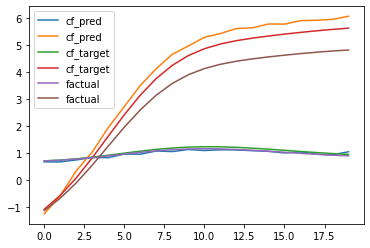

In [21]:
idx = 2
plt.plot(X_pred[idx].detach().cpu().T, label = "cf_pred")
plt.plot(X_target[idx].detach().cpu().T, label = "cf_target")
plt.plot(Y_fact[idx].detach().cpu().T, label = "factual")
plt.legend()
plt.show()

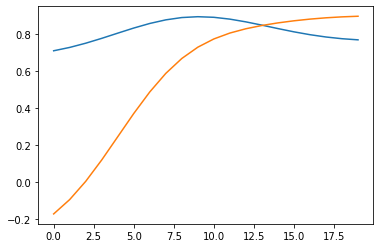

In [34]:
plt.plot(Y_fact[idx].detach().cpu().T)
#plt.plot(X_target[idx].detach().cpu().T)